# carat - rhythmic patterns demo
<pre>
 _  _  __ _ _|_
(_ (_| | (_| |_   computer-aided rhythm analysis toolbox
</pre>

This notebook shows how to extract rhythmic patterns from a recording using [carat](https://github.com/mrocamora/carat) library.

The procedure is based on the tools proposed in:

* *Tools for detection and classification of piano drum patterns from candombe recordings.* Rocamora, Jure, Biscainho. 9th Conference on Interdisciplinary Musicology (CIM), Berlin, Germany. 2014. [CIM2014](https://iie.fing.edu.uy/publicaciones/2014/RJB14/)

**Note:** At this point it is assumed that there are beat annotations for the recording.

The following steps shows how to:

* Load audio input from file
* Load beat annotations from file
* Compute an accentuation feature
* Compute a map of rhythmic patterns
* Group the rhythmic patterns into clusters
* Display the centroids of the obtained clusters
* Display a low-dimensional representation of the patterns

### How to run the notebook
You can download the notebook and run it locally in your computer.

You can also run it in Google Colab by using the following link. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/carat/blob/master/examples/carat_rhythmic_patterns_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Or you can run them using Binder directly in your browser: [![Binder](https://mybinder.org/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/mrocamora/carat/blob/master/examples/carat_rhythmic_patterns_demo.ipynb)

#### Install required packages

You should install the following packages by running the next two cells.

In [ ]:
!pip install carat

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

from mpl_toolkits.mplot3d import Axes3D

from carat import annotations, audio, clustering, display, features, util 

%matplotlib inline

### 1) Load audio and beat annotations
This first step shows how to load an audio file and the corresponding beat/downbeat annotations from a text file.

In [2]:
# use an example audio file provided
audio_path = util.example("ansina_audio")
# or uncomment the line below and point it at your audio file:
# audio_path = '/path/to/your/file/my-recording.wav'

# load audio file
y, sr = audio.load(audio_path, sr=None)

# time corresponding to the audio signal
time = np.arange(0, y.size)/sr

# print sampling rate
print('sr: ', sr)

sr:  44100


**Note:** By default, carat will resample the signal to 22050Hz. But you can disable resamplig as follows:
```
audio.load(audio_path, sr=None)
```

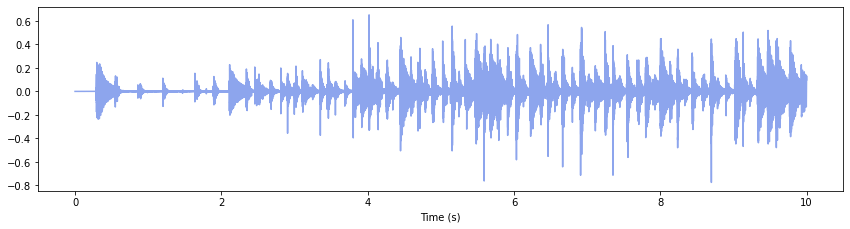

In [3]:
# to plot audio waveform let's load only 10 seconds of the same audio file
y_short, sr = audio.load(audio_path, sr=None, duration=10.0)

plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
display.wave_plot(y_short, sr, ax=ax1)
plt.tight_layout()

We can listen to the first 10 seconds of the audio file. 

**Note:** This example is tailored towards the rhythmic patterns of the **lowest sounding** of the three drum types taking part in the recording, so the analysis focuses on the **low frequencies**. You may need headphones to listen to the low frequencies. 

In [4]:
ipd.Audio(y_short, rate=sr)

In [5]:
# use annotations provided for the example audio file
annotations_path = util.example("ansina_beats")
# or uncomment the line below and point it at your annotations file:
# annotations_path = '/path/to/your/file/my-annotations.csv'

# load beats and beat labels
beats, beat_labs = annotations.load_beats(annotations_path)
# load downbeats and downbeat labels
downbeats, downbeat_labs = annotations.load_downbeats(annotations_path)

# print the first 10 beats and beat labels
print(beats[:10])
print(beat_labs[:10])
# print the first 3 downbeats and downbeat labels
print(downbeats[:3])
print(downbeat_labs[:3])

[0.54857143 0.99387755 1.46140589 1.8953288  2.33265306 2.80902494
 3.25365079 3.68412698 4.11530612 4.5815873 ]
['1.1', '1.2', '1.3', '1.4', '2.1', '2.2', '2.3', '2.4', '3.1', '3.2']
[0.54857143 2.33265306 4.11530612]
['1.1', '2.1', '3.1']


**Note 1:** It is assumed that the beat annotations are provided as a text file (csv). Apart from the time data (mandatory) a label can be given for each beat (optional). The time data is assumed to be given in seconds. The labels may indicate the beat number within the rhythm cycle (e.g. 1.1, 1.2, or 1, 2).

By default the columns are assumed to be separated by a comma, but you can specify another separating string by setting the `delimiter` parameter value. For instance a blank space:
```
beats, beat_labs = annotations.load_downbeats(annotations_path, delimiter=' ')
```
**Note 2:** The same annotations file is used for both beats and downbeats. This is based on annotation labels that provide a particular string to identify the downbeats. In this case, this string is `.1`, and is the one used by default. You can specify the string to look for in the labels data to select downbeats by setting the `downbeat_label` parameter value. For instance, just the number 1:
```
downbeats, downbeat_labs = annotations.load_downbeats(annotations_path, downbeat_label='1')
```

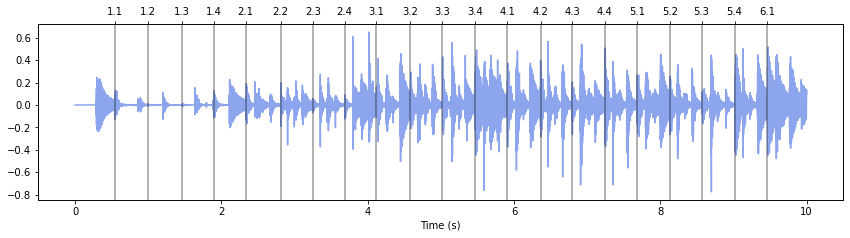

In [6]:
# plot waveform and beats for the first 10 seconds
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
display.wave_plot(y_short, sr, ax=ax1, beats=beats, beat_labs=beat_labs)
plt.tight_layout()

### 2) Compute accentuation feature

This second step show how to compute an accentuation feature from the audio waveform based on the [Spectral flux](https://en.wikipedia.org/wiki/Spectral_flux), that consists in seizing the changes in the spectral magnitude of the audio signal along different frequency bands. In principle, the feature value is high when a note has been articulated and close to zero otherwise.

**Note:** This example is tailored towards the rhythmic patterns of the **lowest sounding** of the three drum types taking part in the recording, so the analysis focuses on the **low frequencies** (20 to 200 Hz).

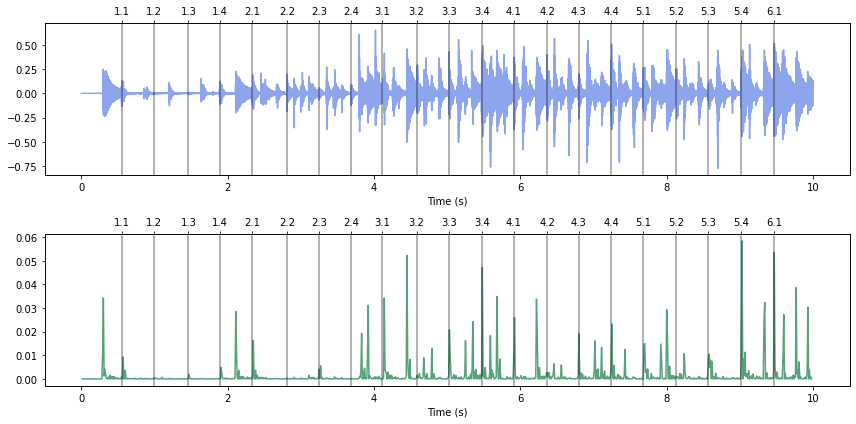

In [7]:
# We focus on the low frequency band (20 to 200 Hz), to get the rhythmic patterns of the low sounding drum (piano)
acce, times, _ = features.accentuation_feature(y_short, sr, minfreq=20, maxfreq=200)

# plot waveform and accentuation feature
plt.figure(figsize=(12,6))
# plot waveform
ax1 = plt.subplot(2, 1, 1)
display.wave_plot(y_short, sr, ax=ax1, beats=beats, beat_labs=beat_labs)
# plot accentuation feature
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
display.feature_plot(acce, times, ax=ax2, beats=beats, beat_labs=beat_labs)
plt.tight_layout()

### 3) Compute feature map

The accentuation feature is organized into a feature map. First, the feature signal is time-quantized to the rhythm metric structure by considering a grid of tatum pulses equally distributed within the annotated beats. The corresponding feature value is taken as the maximum within window centered at the frame closest to each tatum instant. This yields feature vectors whose coordinates correspond to the tatum pulses of the rhythm cycle (or bar). Finally, a feature map of the cycle-length rhythmic patterns of the audio file is obtained by building a matrix whose columns are consecutive feature vectors.

In [8]:
# We focus on the low frequency band (20 to 200 Hz), to get the rhythmic patterns of the low sounding drum (piano)
acce, times, _ = features.accentuation_feature(y, sr, minfreq=20, maxfreq=200)

# number of beats per bar
n_beats = int(round(beats.size/downbeats.size))
# you have to provide the number of tatums (subdivisions) per beat
n_tatums = 4

# Compute the feature map from the feature signal and 
map_acce, _, _, _ = features.feature_map(acce, times, beats, downbeats, n_beats=n_beats, n_tatums=n_tatums)

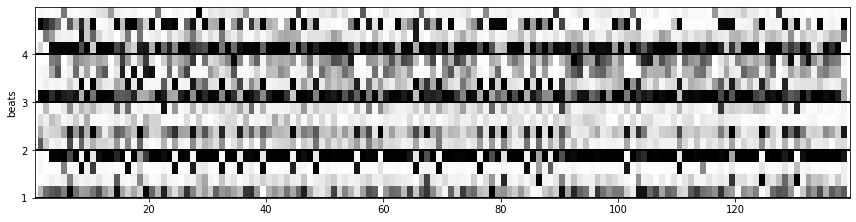

In [9]:
# plot feature map
plt.figure(figsize=(12,6))
ax1 = plt.subplot(211)
display.map_show(map_acce, ax=ax1, n_tatums=n_tatums)
plt.tight_layout()

This feature map representation enables the inspection of the patterns evolution over time, as well as their similarities and differences, in a very informative way. Note that if a certain tatum pulse is articulated for several consecutive bars, it will be shown as a dark horizontal line in the map. Conversely, changes in repetitive patterns are readily distinguishable as variations in the distribution of feature values.

### 4) Group rhythmic patterns into clusters

Next, we'll group rhythmic patterns into clusters to aid the analysis of their differences and similarities. This is done using the classical [K-means](https://en.wikipedia.org/wiki/K-means_clustering) method with [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) (but other clustering methods and distance measures can be used too). The number of clusters `n_clusters` has to be specified as an input parameter.

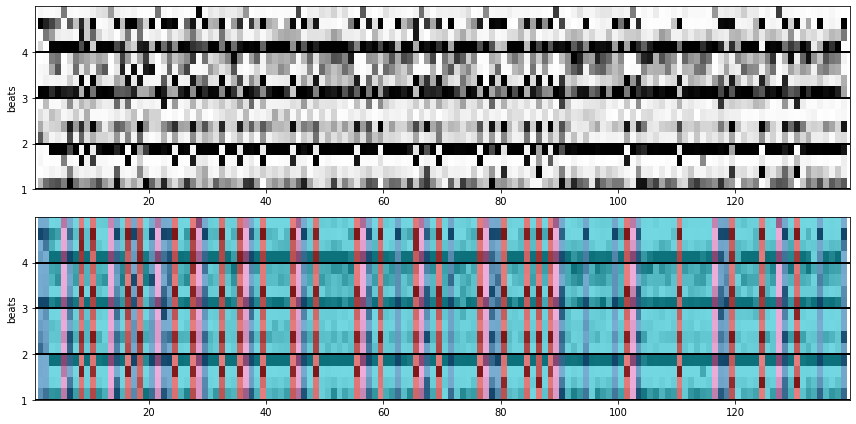

In [10]:
# set the number of clusters to look for
n_clusters = 4

# clustering of rhythmic patterns
cluster_labs, centroids, _ = clustering.rhythmic_patterns(map_acce, n_clusters=n_clusters)

plt.figure(figsize=(12,6))
# plot feature map
ax1 = plt.subplot(211)
display.map_show(map_acce, ax=ax1, n_tatums=n_tatums)
# plot feature map with clusters in colors
ax2 = plt.subplot(212)
display.map_show(map_acce, ax=ax2, n_tatums=n_tatums, clusters=cluster_labs)

plt.tight_layout()

We can consider the centroids of each cluster as a representative rhythmic pattern of the group, as shown below.

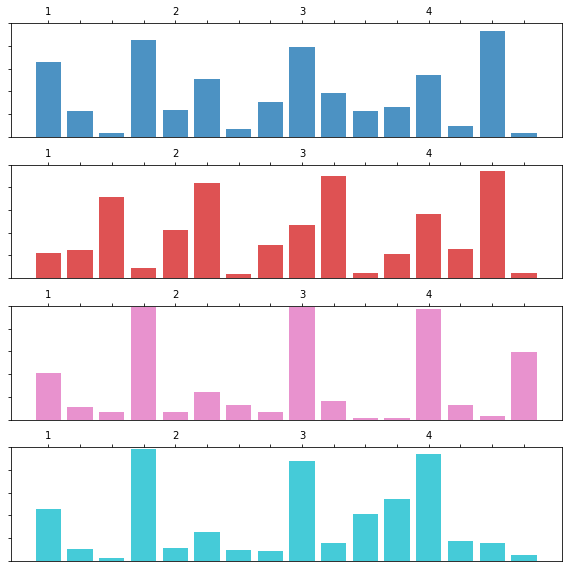

In [11]:
# plot cluster centroids
fig = plt.figure(figsize=(8,8))
display.centroids_plot(centroids, n_tatums=n_tatums)

plt.tight_layout()

We can listen to a pattern of each kind using the code below.

**Note:** This example is tailored towards the rhythmic patterns of the **lowest sounding** of the three drum types taking part in the recording, so the analysis focuses on the **low frequencies**. You may need headphones to listen to the low frequencies. 

In [12]:
# rhythmic pattern number for patterns of each kind
ind1, ind2, ind3, ind4 = 4, 5, 6, 8

# audio segments for each pattern
y1 = util.beat2signal(y, time, downbeats, ind1-1)
y2 = util.beat2signal(y, time, downbeats, ind2-1)
y3 = util.beat2signal(y, time, downbeats, ind3-1)
y4 = util.beat2signal(y, time, downbeats, ind4-1)

In [13]:
ipd.Audio(y1, rate=sr)

In [14]:
ipd.Audio(y2, rate=sr)

In [15]:
ipd.Audio(y3, rate=sr)

In [16]:
ipd.Audio(y4, rate=sr)

### 5)  Low-dimensional representation of the patterns

For visualization purposes, the patterns are mapped to a low dimensional space. This representation can be useful to select the number of clusters, or to spot outliers. There are several approaches for dimensionality reduction among which isometric mapping, [Isomap](https://en.wikipedia.org/wiki/Isomap), was selected (other embedding methods can be also applied). Isomap is preferred since it is capable of keeping the levels of similarity among the original patterns after being mapped to the lower dimensional space. Besides, it allows the projection of new patterns onto the low-dimensional space.

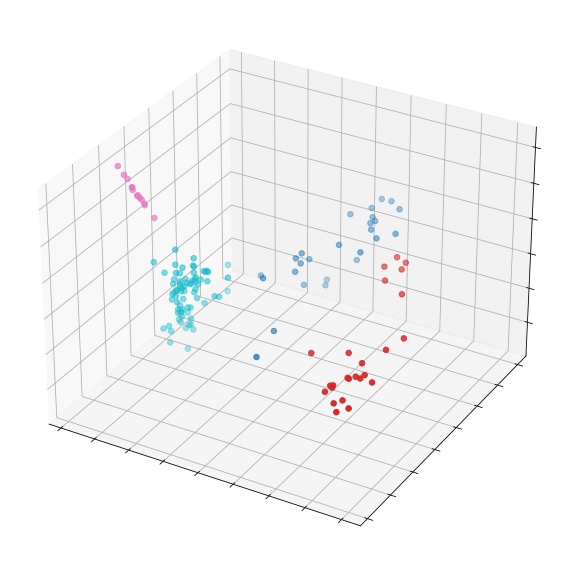

In [17]:
# number of dimensions to map on
n_dims = 3

# manifold learning for dimensionality reduction
map_emb = clustering.manifold_learning(map_acce, method='isomap', n_components=n_dims)

# plot low-dimensional embedding of feature data
fig = plt.figure(figsize=(10, 8))
# NOTE: 3D plots need Axes3D from mpl_toolkits.mplot3d  
ax3 = fig.add_subplot(111, projection='3d')
display.embedding_plot(map_emb, ax=ax3, clusters=cluster_labs, s=30)

plt.tight_layout()